In [9]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer  # PowerTransformer ditambahkan di sini
import numpy as np

In [10]:
# --- Cell 1: Load Dataset ---
# Load dataset
file_path = 'dataset/air_quality_health_impact_data.csv'
dataset = pd.read_csv(file_path)

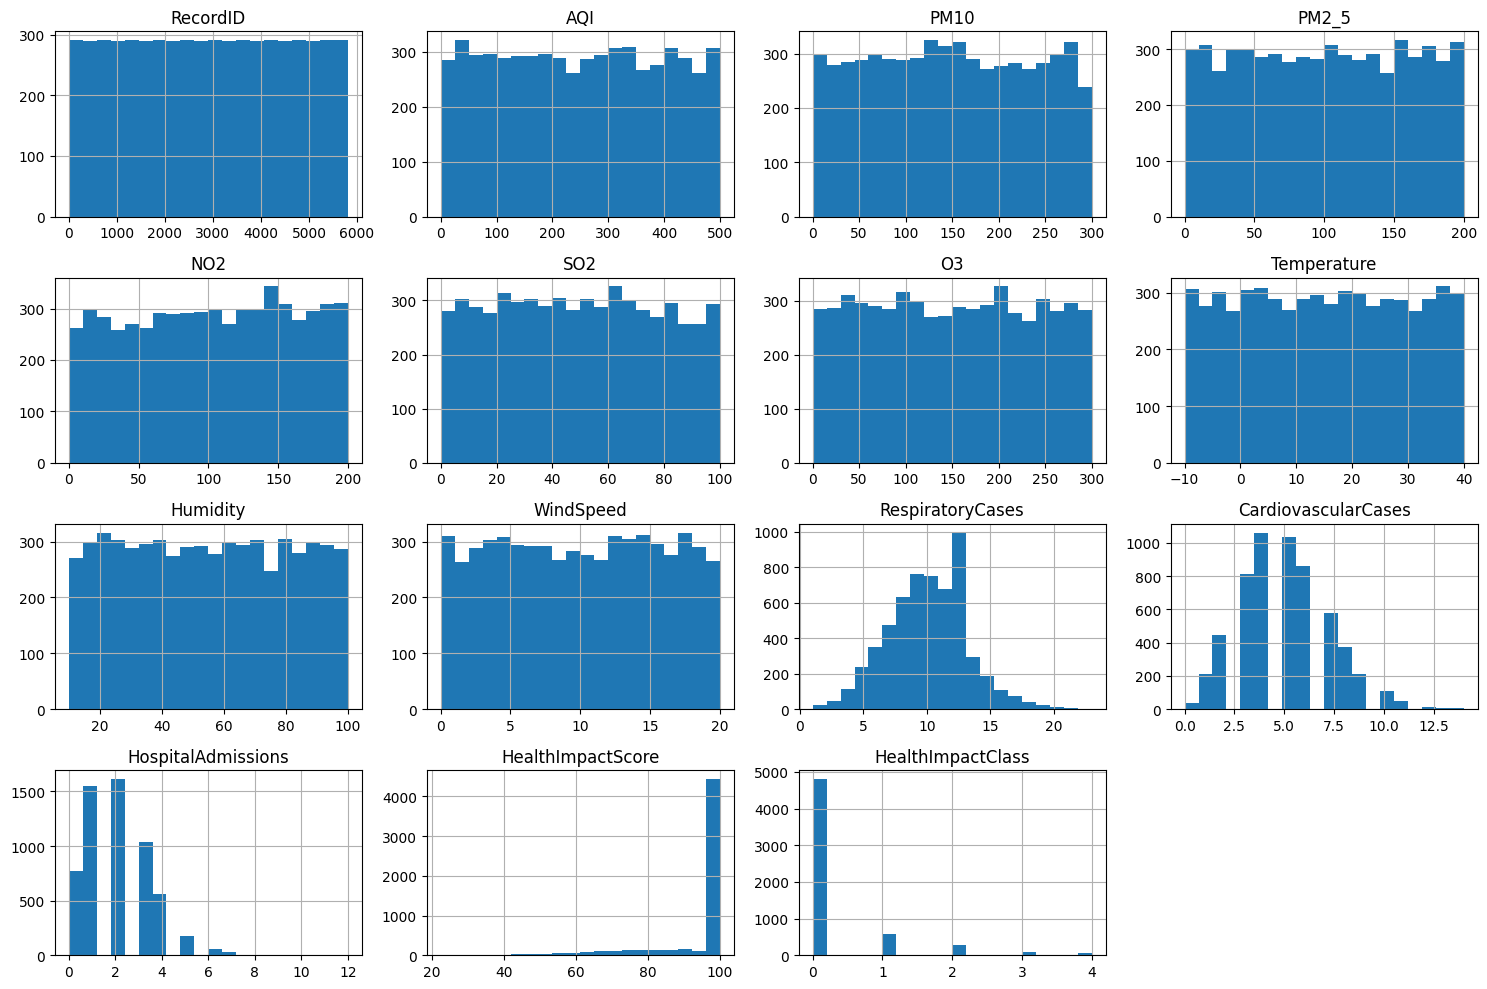

In [11]:
# --- Cell 2: EDA - Distribusi Fitur Numerik ---
# 1. EDA: Analisis Data Eksploratif
# Plot distribusi fitur numerik
dataset.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()

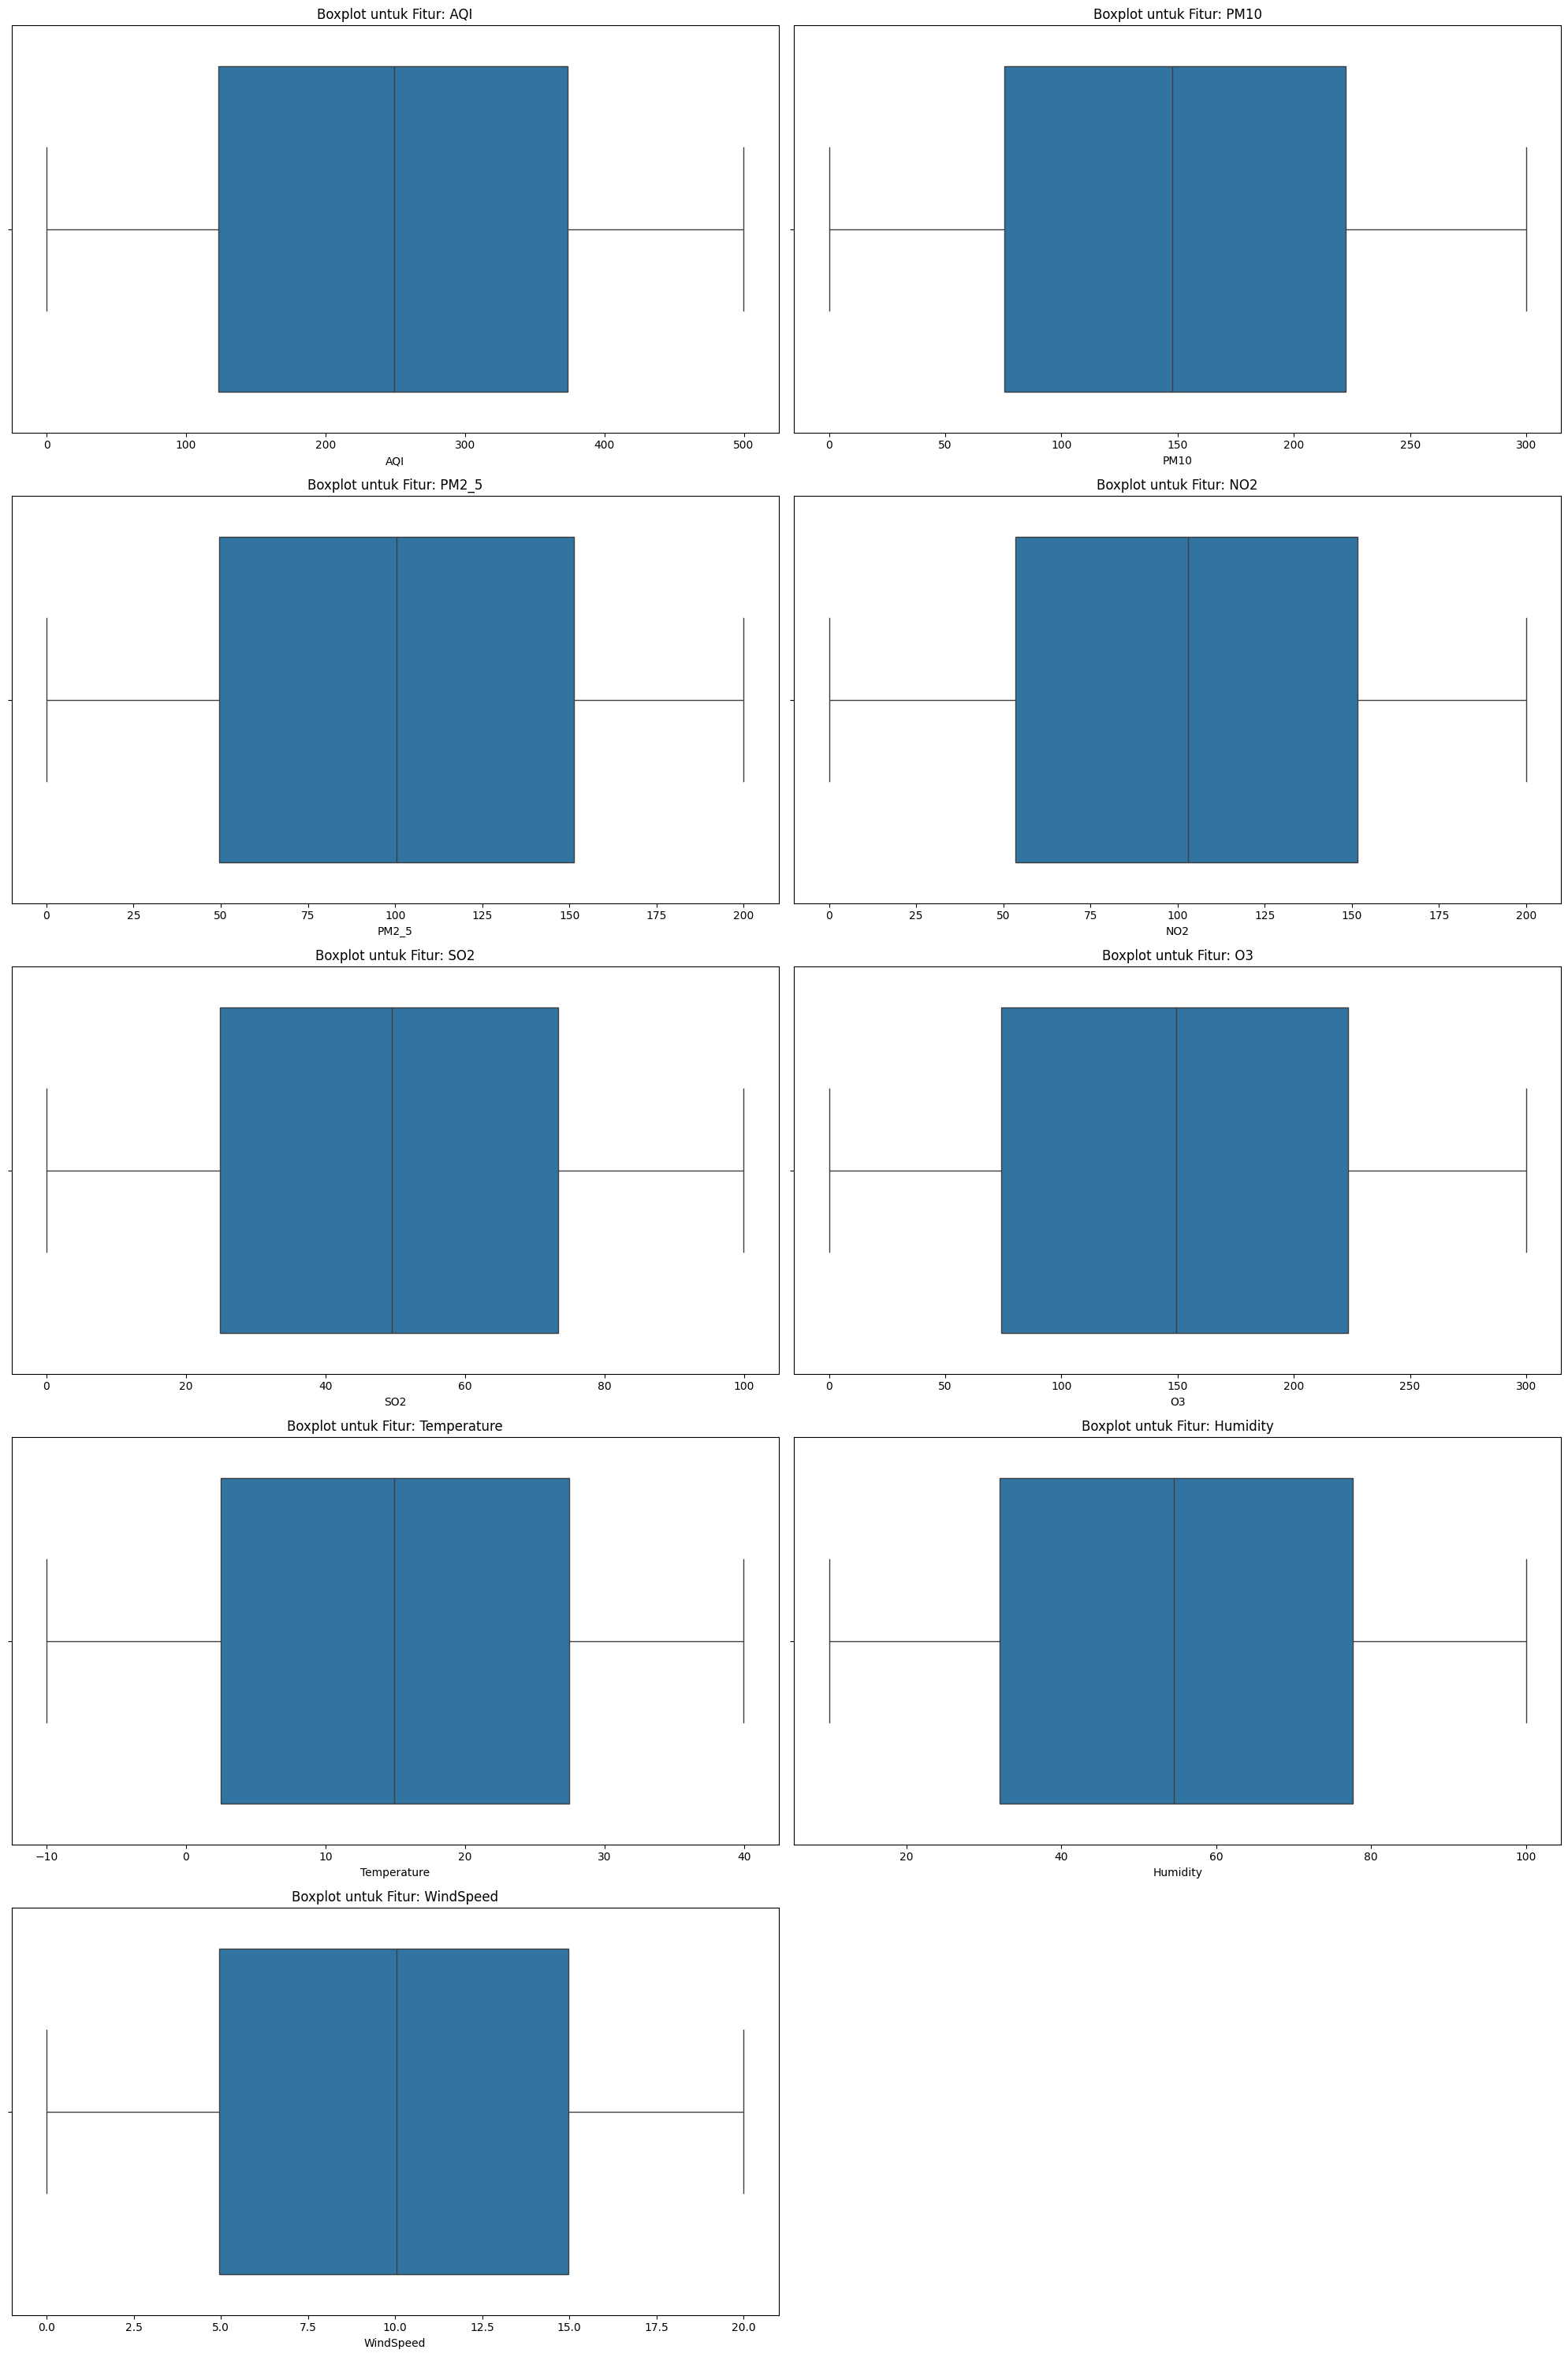

In [12]:
# --- Cell 3: EDA - Boxplot untuk Identifikasi Outlier ---
# Membuat boxplot untuk setiap fitur numerik untuk mengidentifikasi outlier
features_to_check = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']
plt.figure(figsize=(20, 30))

for idx, feature in enumerate(features_to_check):
    plt.subplot(5, 2, idx + 1)
    sns.boxplot(x=dataset[feature])
    plt.title(f"Boxplot untuk Fitur: {feature}")

plt.tight_layout()
plt.show()

In [13]:
# --- Cell 4: Penanganan Outliers ---
# 2. Penanganan Outliers
# Clipping outliers pada persentil ke-95 untuk setiap fitur
for feature in features_to_check:
    upper_limit = dataset[feature].quantile(0.95)
    dataset[feature] = dataset[feature].clip(upper=upper_limit)

In [26]:
# --- Cell 5: Feature Engineering ---
# 3. Feature Engineering: Membuat Fitur Tambahan
# Membuat fitur tambahan berdasarkan gabungan beberapa parameter kualitas udara
dataset['CombinedAirQualityIndex'] = (dataset['PM2_5'] + dataset['PM10'] + dataset['NO2']) / 3

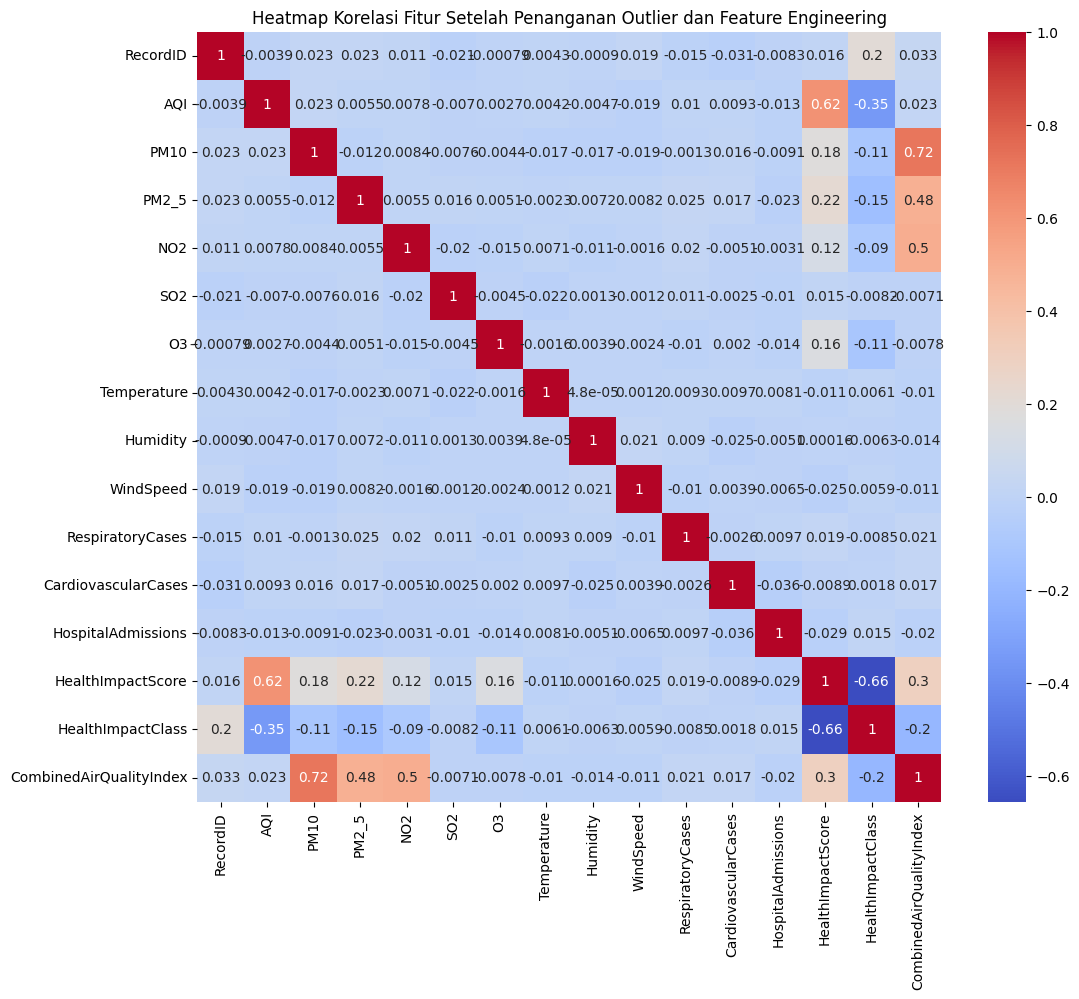

In [28]:
# --- Cell 6: Feature Selection dan Korelasi ---
# 4. Feature Selection berdasarkan Korelasi
# Menampilkan heatmap untuk melihat korelasi antar fitur
plt.figure(figsize=(12, 10))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur Setelah Penanganan Outlier dan Feature Engineering")
plt.show()

features = ['AQI', 'PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']
target = 'HealthImpactScore'

# Membuat variabel fitur dan target
X = dataset[features]
y = dataset[target]

Skewness dari target (HealthImpactScore): -2.3507085942941197


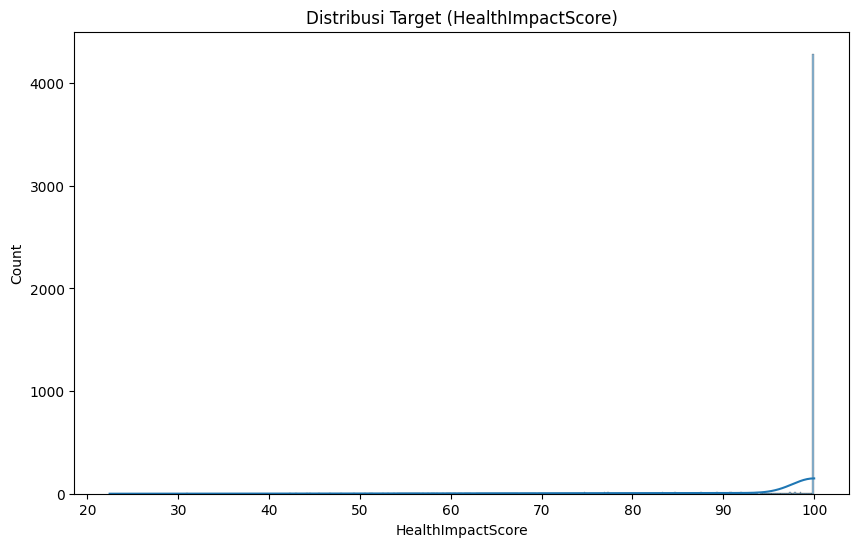

Transformasi Yeo-Johnson dilakukan pada target.


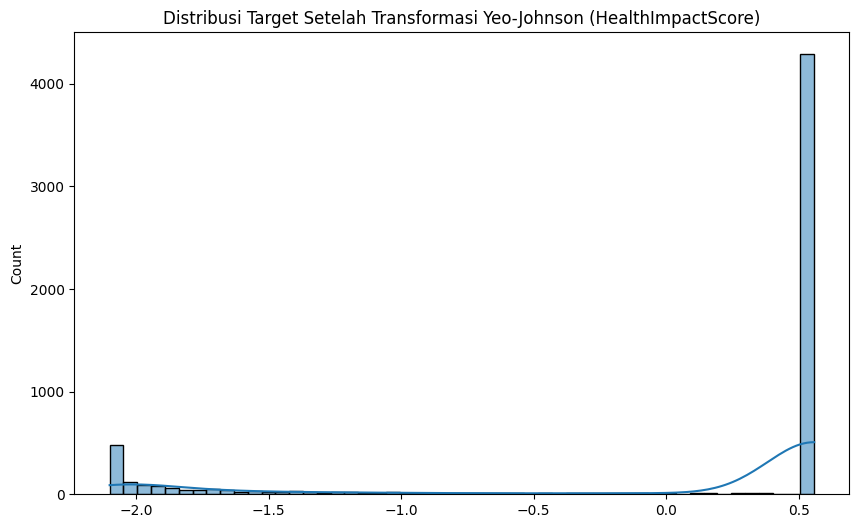

In [29]:
# --- Cell 7: Pemeriksaan Distribusi Target ---
# 5. Pemeriksaan Distribusi Target
y_skewness = y.skew()
print("Skewness dari target (HealthImpactScore):", y_skewness)
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True)
plt.title("Distribusi Target (HealthImpactScore)")
plt.show()

# Jika distribusi target sangat skewed negatif, menggunakan transformasi Yeo-Johnson
if y_skewness < -1:
    pt = PowerTransformer(method='yeo-johnson')
    y_transformed = pt.fit_transform(y.values.reshape(-1, 1))
    y = y_transformed.ravel()  # Merubah kembali ke bentuk array 1 dimensi
    print("Transformasi Yeo-Johnson dilakukan pada target.")

    # Visualisasi ulang distribusi target setelah transformasi Yeo-Johnson
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=True)
    plt.title("Distribusi Target Setelah Transformasi Yeo-Johnson (HealthImpactScore)")
    plt.show()

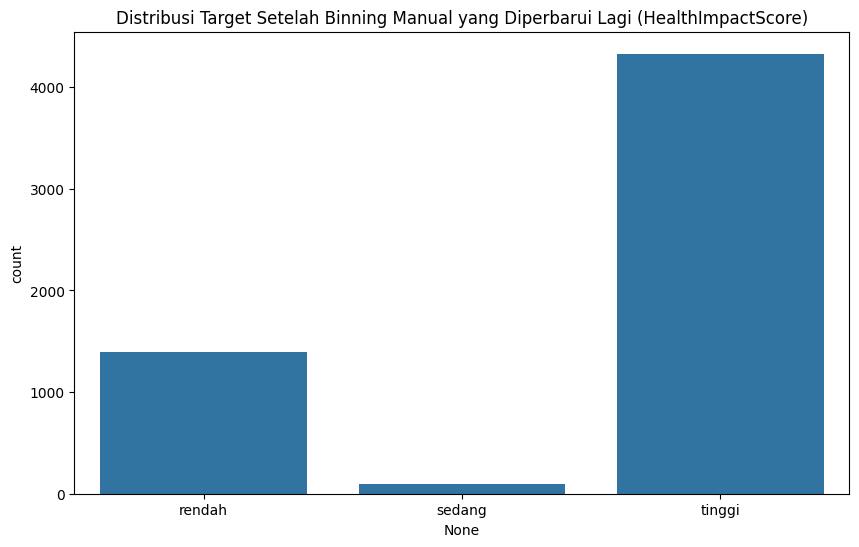

In [30]:
# Pastikan y masih berupa data numerik. Jika y telah diubah menjadi string atau kategori, kita perlu kembali ke bentuk numeriknya.
# Misalnya, kita gunakan kembali y sebelum dilakukan binning
y_numeric = pd.Series(y).astype(float)  # Memastikan bahwa y berbentuk numerik

# --- Cell 8: Binning Target ke dalam Kategori Secara Manual (Diperbarui Lagi) ---
# Membagi target menjadi 3 kategori dengan batas yang lebih diperbaiki: rendah, sedang, tinggi
# Menyesuaikan batas binning secara manual
y_binned = pd.cut(y_numeric, bins=[-np.inf, -0.25, 0.25, np.inf], labels=['rendah', 'sedang', 'tinggi'])

# Visualisasi ulang distribusi setelah binning
plt.figure(figsize=(10, 6))
sns.countplot(x=y_binned)
plt.title("Distribusi Target Setelah Binning Manual yang Diperbarui Lagi (HealthImpactScore)")
plt.show()

# Menggunakan y_binned sebagai target untuk modeling selanjutnya
y = y_binned

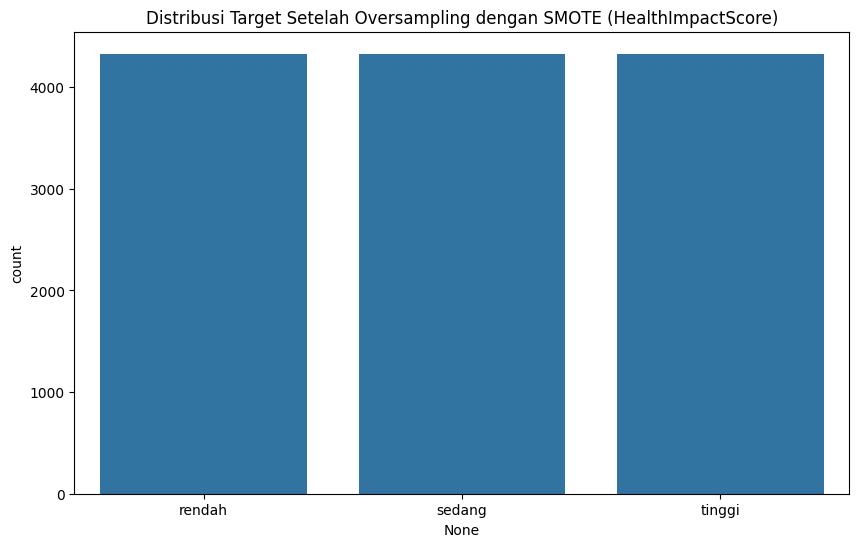

In [31]:
from imblearn.over_sampling import SMOTE

# Melakukan oversampling dengan SMOTE untuk mencapai keseimbangan
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Visualisasi distribusi data setelah SMOTE
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled)
plt.title("Distribusi Target Setelah Oversampling dengan SMOTE (HealthImpactScore)")
plt.show()

# Menggunakan data yang telah diresampling untuk modeling selanjutnya
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42, stratify=y_resampled)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [32]:
# --- Cell 9: Pembagian Data ---
# Membagi Data menjadi Training, Dev, dan Test Set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [33]:
# --- Cell 10: Normalisasi Data ---
# 7. Normalisasi Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)
X_test_scaled = scaler.transform(X_test)

# Menampilkan bentuk data setelah pemrosesan selesai
print("Bentuk data latih:", X_train_scaled.shape)
print("Bentuk data dev:", X_dev_scaled.shape)
print("Bentuk data uji:", X_test_scaled.shape)

Bentuk data latih: (3486, 9)
Bentuk data dev: (1162, 9)
Bentuk data uji: (1163, 9)
